# PyNEST - Spatial Networks

**Modeling networks of spiking neurons with spatial connectivity using NEST**

**CNS 2021, 03.07.2021**

**[Jasper Albers](mailto:j.albers@fz-juelich.de), [Barna Zajzon](mailto:b.zajzon@fz-juelich.de)**

<table><tr>
<td> 
    <div style="text-align:center">
        <img src="img/sincich_2001.png" alt="spatial connectivity" width="1200" align="left"/> <br />
    Sincich et al. (2001): Oriented Axon Projections in Primary Visual Cortex of the Monkey </div>
</td>
   
<td> 
    <img width="200"/>
</td>
    
<td> 
    <div style="text-align:center">
        <img src="img/packer_2011.png" alt="exponential profile" width="300" align="center"/> <br />
    Packer et al. (2011): Dense, Unspecific Connectivity of Neocortical Parvalbumin-Positive Interneurons: A Canonical Microcircuit for Inhibition? </div>
</td>
    
</tr></table>

In this notebook we will adapt the model of 

`Brunel (2000) Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons. Journal of Computational Neuroscience 8(3):183-208`

to a spatial neural network and investigate the implications on dynamics.

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
# import NEST & NEST rasterplot
import nest
import nest.raster_plot

___
## Setup

### Parameters -- same as before

In [2]:
# simulation parameters
simtime = 1000.            # simulation time (ms)
dt = 0.1                   # simulation resolution (ms)

# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 5000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
N_rec = 50                 # record from 100 (50 e + 50 i) neurons
CE = 1000                  # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}

# external input parameters
nu_th = V_th / (w * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 2.0 * nu_th        # set external rate above threshold
p_rate = 1e3 * nu_ex       # external rate (spikes/s)

### NEST initialization -- same as before

In [3]:
# configure kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'resolution': dt,      # set simulation resolution
    'print_time': True,    # enable printing of simulation progress (-> terminal)
    'local_num_threads': 2 # use two threads to build & simulate the network
})

# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)

# create poisson generator and set 'rate' to p_rate
pgen = nest.Create('poisson_generator', params={'rate': p_rate})

# create spike detectors
spikes_e = nest.Create('spike_recorder')
spikes_i = nest.Create('spike_recorder')

___
## Spatially distributed neurons 

We want to endow the neurons with the notion of space. This functionality is built right into NEST 3:

In [4]:
# define positions via a distribution in space (free, grid and list possible)
pos_e = nest.spatial.free(
           pos=nest.random.uniform(min=-0.5, max=0.5),
           num_dimensions=2)
pos_i = nest.spatial.free(
           pos=nest.random.uniform(min=-0.5, max=0.5),
           num_dimensions=2)

# create layers of spatially distributed neurons according to position objects
layer_e = nest.Create('iaf_psc_delta', NE, positions=pos_e)
layer_i = nest.Create('iaf_psc_delta', NI, positions=pos_i)

Below we can check what these layers look like in 2D space.

<IPython.core.display.Javascript object>


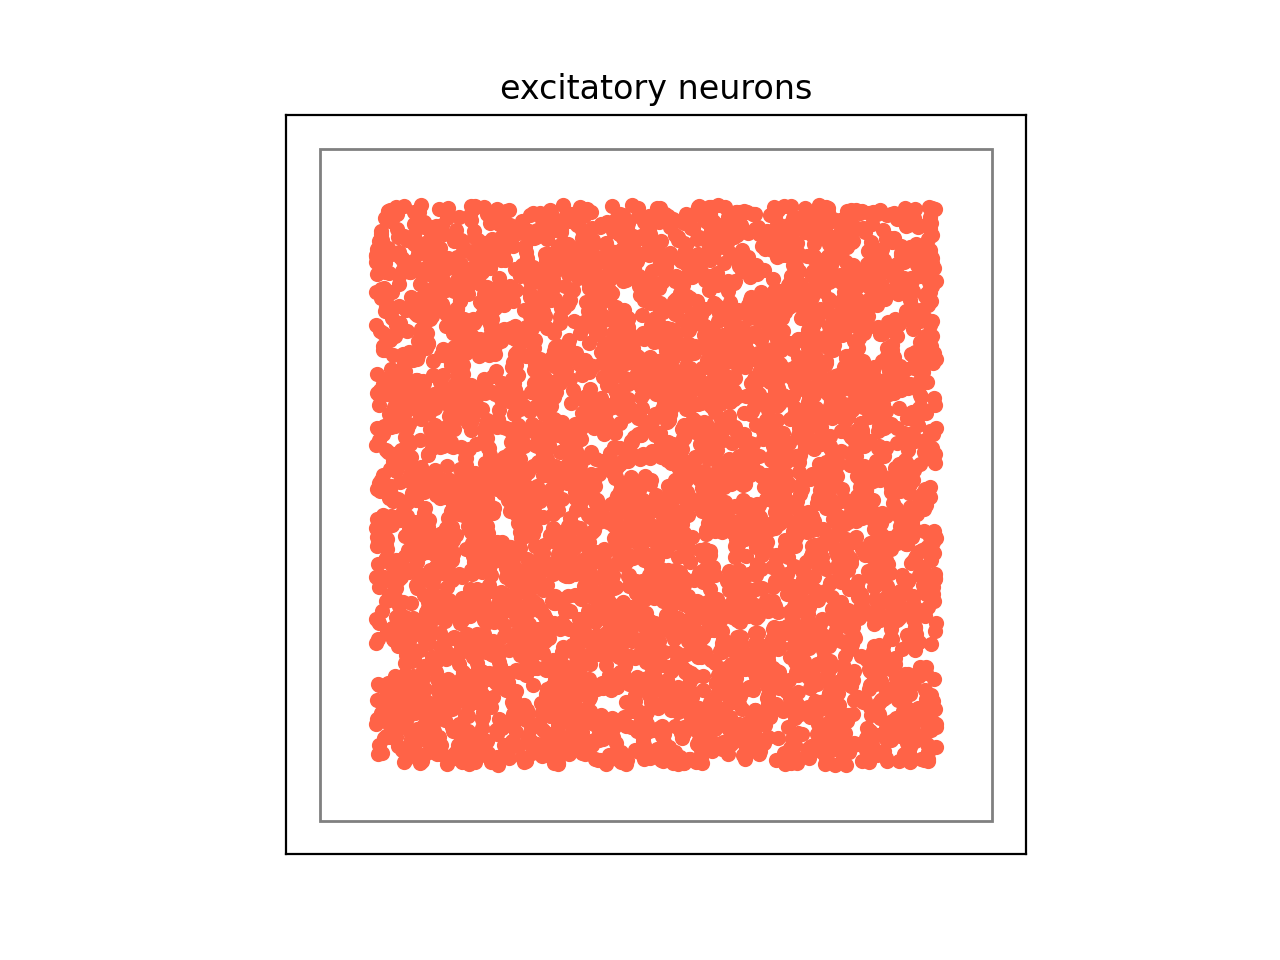

<IPython.core.display.Javascript object>


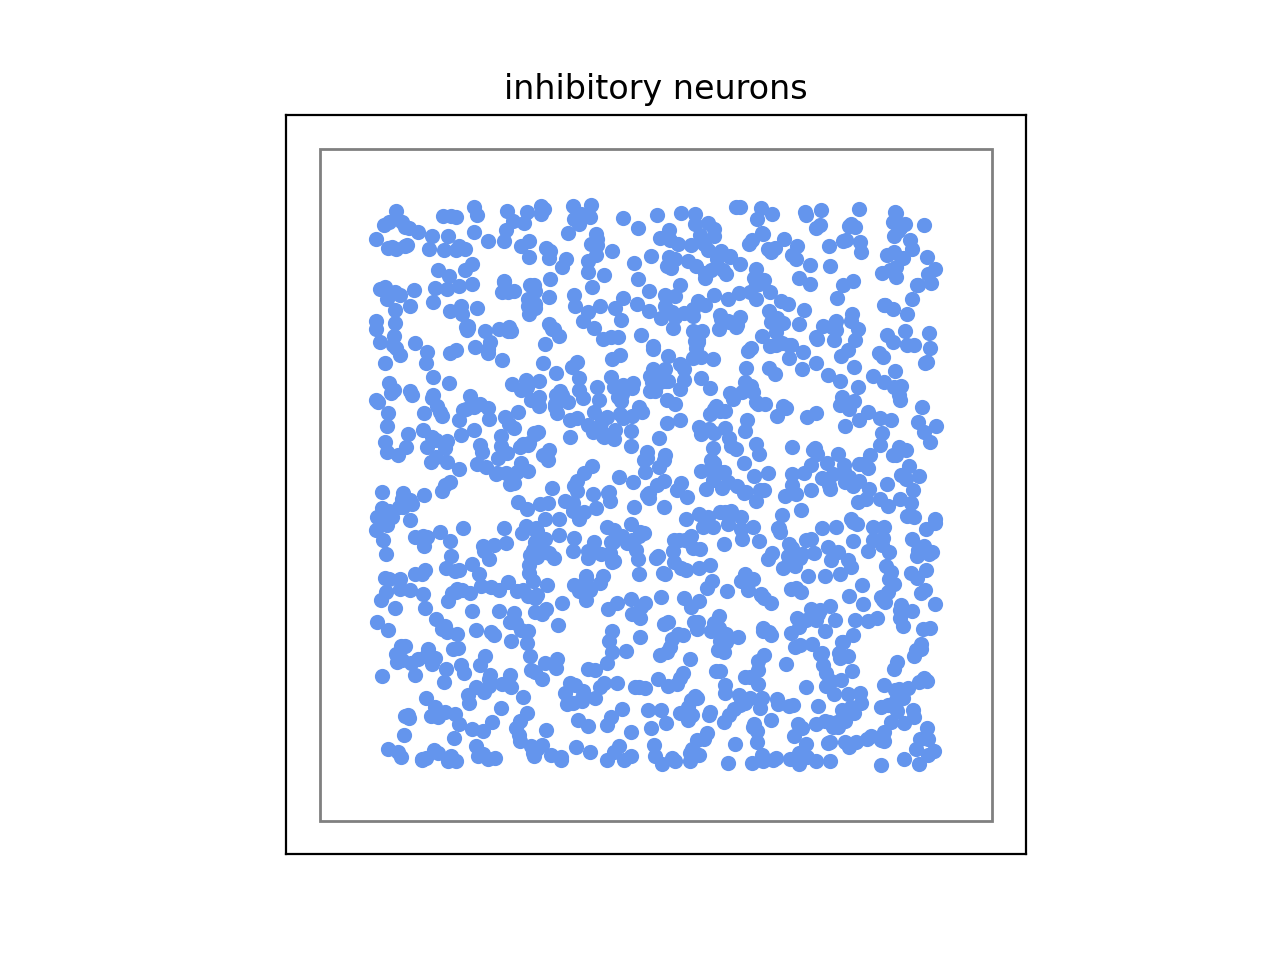

Text(0.5, 1.0, 'inhibitory neurons')

In [5]:
plot_e = nest.PlotLayer(layer_e, nodecolor='tomato')
plt.title('excitatory neurons', figure=plot_e)

plot_i = nest.PlotLayer(layer_i, nodecolor='cornflowerblue')
plt.title('inhibitory neurons', figure=plot_i)

## Spatial Connectivity

Our neurons are now arranged in 2D layers. What will happen if we use the same connection methods as before?

In [6]:
# synapse specification
syn_exc = {'delay': d, 'weight': w}
syn_inh = {'delay': d, 'weight': - g * w}

# connection specification
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}

Introducing the star of the show: spatial connectivity!

In [7]:
prob_distribution = nest.spatial_distributions.gaussian(nest.spatial.distance, mean=0., std=0.05)

conn_exc = {'rule': 'pairwise_bernoulli',
            'p': prob_distribution}

Connecting the layers of neurons works just as before:

In [8]:
nest.Connect(layer_i, layer_e, conn_inh, syn_inh)
nest.Connect(layer_i, layer_i, conn_inh, syn_inh)
nest.Connect(layer_e, layer_e, conn_exc, syn_exc)
nest.Connect(layer_e, layer_i, conn_exc, syn_exc)

Let's see what this connectivity actually looks like in space. 

<IPython.core.display.Javascript object>


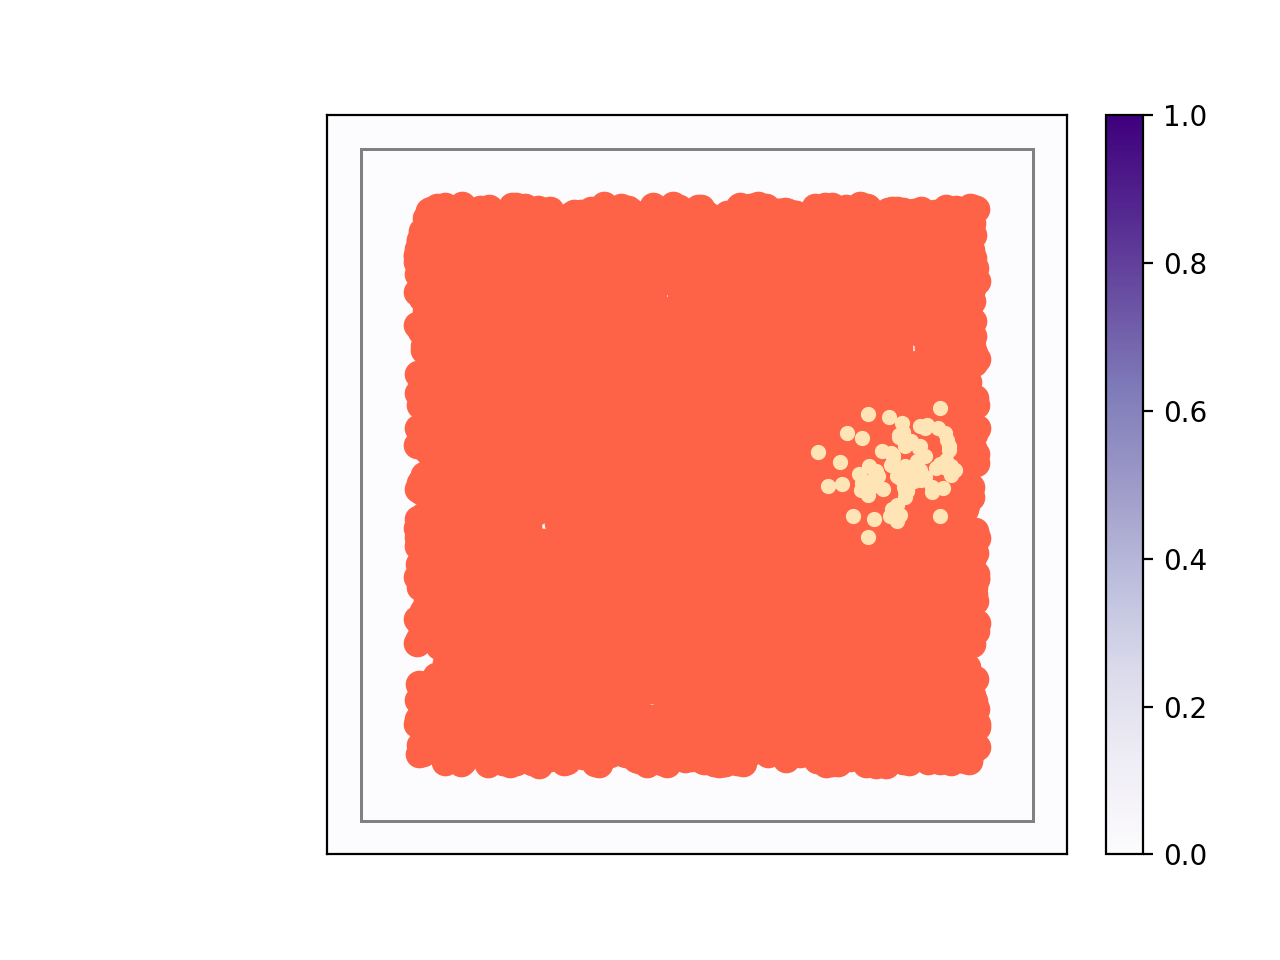

In [9]:
fig_e = nest.PlotLayer(layer_e, nodecolor='tomato', nodesize=80)

source = layer_e[5]
target_plot = nest.PlotTargets(source, layer_e, fig=fig_e,
                 probability_parameter=prob_distribution,
                 src_size=250, tgt_color='moccasin', tgt_size=20,
                 probability_cmap='Purples')

<IPython.core.display.Javascript object>


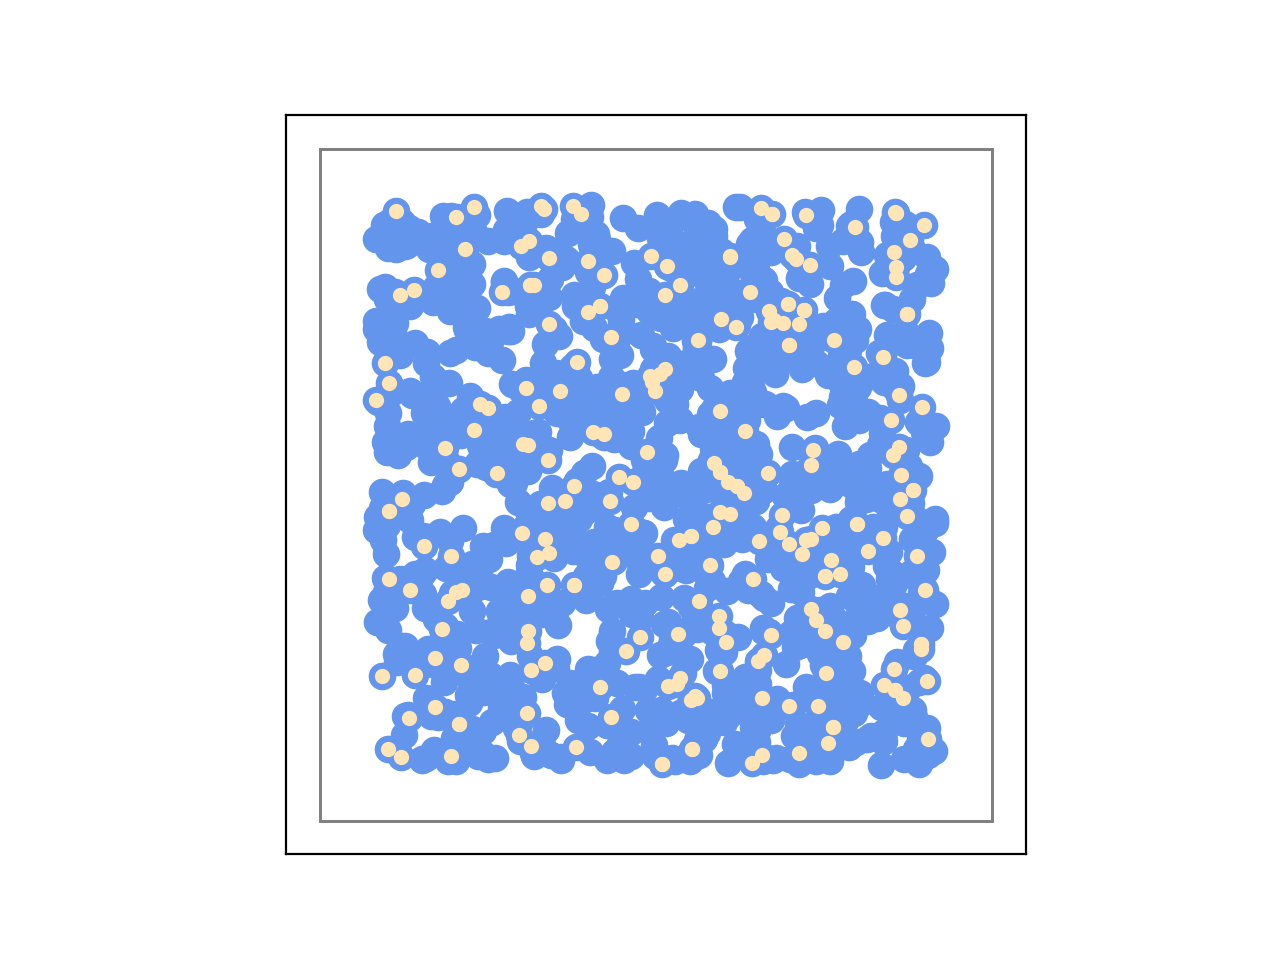

In [10]:
fig_i = nest.PlotLayer(layer_i, nodecolor='cornflowerblue', nodesize=80)

source = layer_i[5]
target_plot = nest.PlotTargets(source, layer_i, fig=fig_i,
                 src_size=250, tgt_color='moccasin', tgt_size=20,
                 probability_cmap='Greens')

## Simulating the network

External input is again represented as Poisson input.

In [11]:
# connect poisson generator using the excitatory connection weight
nest.Connect(pgen, layer_i, syn_spec=syn_exc)
nest.Connect(pgen, layer_e, syn_spec=syn_exc)

Recording also works the same (--> spike recorders)

In [12]:
# connect N_rec excitatory / inhibitory neurons to spike recorder
nest.Connect(layer_e[:N_rec], spikes_e)
nest.Connect(layer_i[:N_rec], spikes_i)

In [13]:
# simulate
nest.Simulate(simtime) 

In [14]:
# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_e, 'n_events')[0]
events_in = nest.GetStatus(spikes_i, 'n_events')[0]
rate_ex = events_ex / simtime / N_rec * 1e3
rate_in = events_in / simtime / N_rec * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz'.format(mean_rate))

Mean firing rate: 10.440000000000001 Hz


<IPython.core.display.Javascript object>


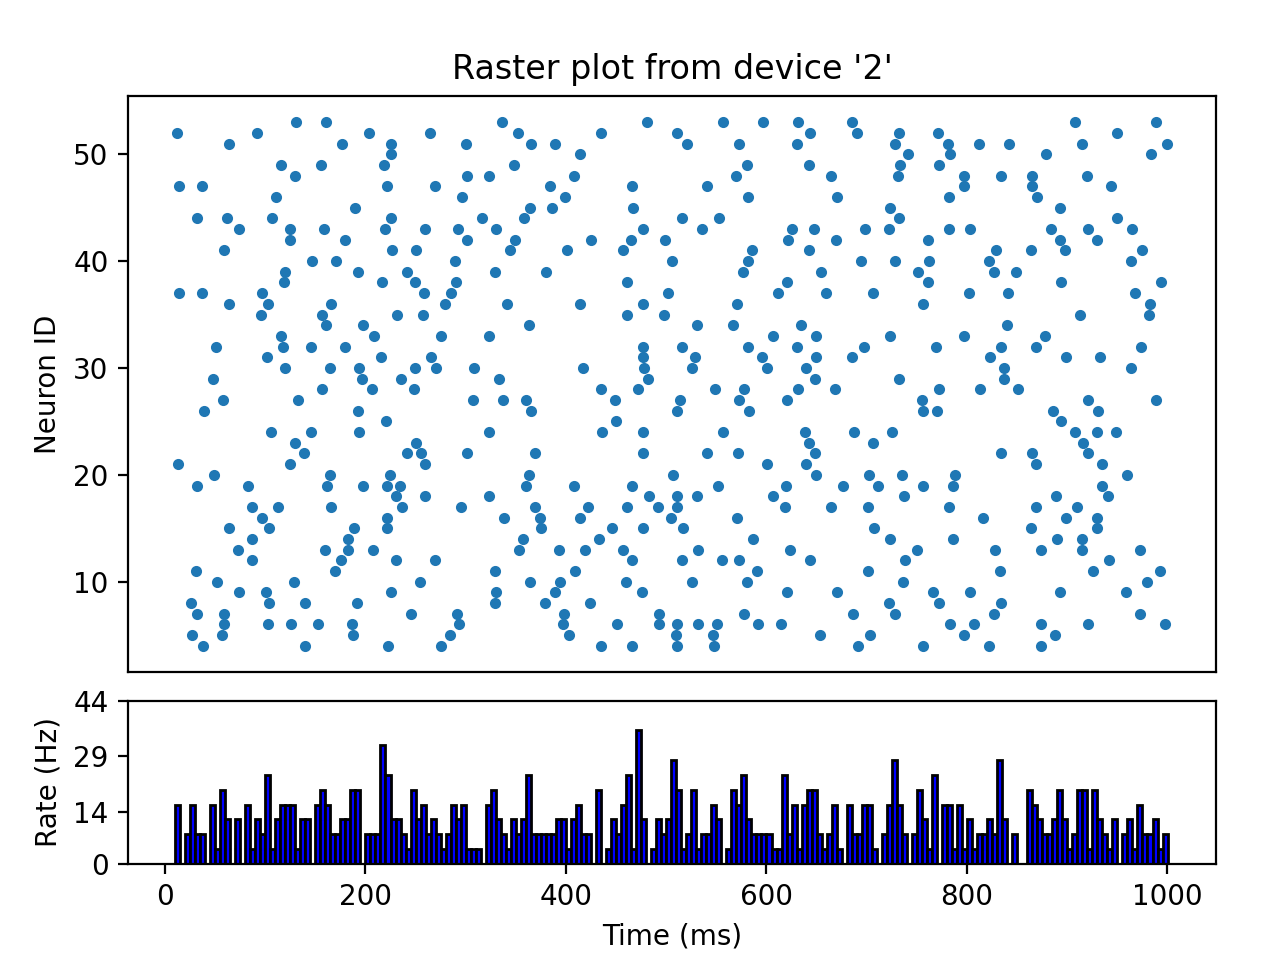

<IPython.core.display.Javascript object>


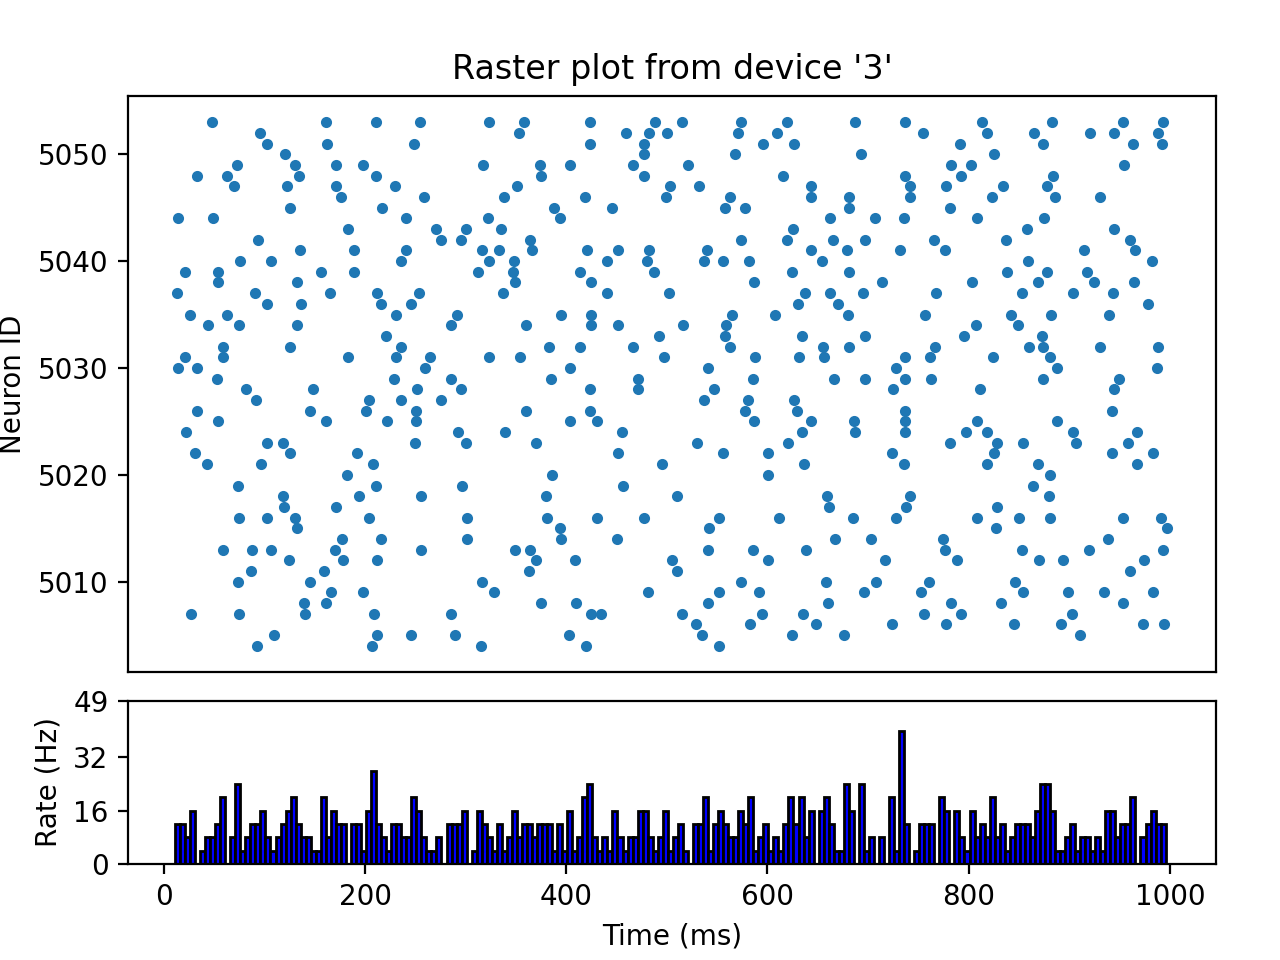

In [15]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_e, hist=True)
nest.raster_plot.from_device(spikes_i, hist=True)

In [18]:
len(nest.GetConnections(source=layer_e, target=layer_e[5]))

73

## Further material

easy-to-read guide to spatial networks in NEST: https://nest-simulator.readthedocs.io/en/latest/guides/spatial/guide_spatially_structured_networks.html